In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
# Librería matriz de confusión
from sklearn.metrics import confusion_matrix
# Librería para curva de ROC
from sklearn.metrics import roc_curve, auc
# Librerias para regresión logística
import statsmodels.api as sm
import statsmodels.formula.api as smf
# Libreria para trabajar cadenas de texto
import re

In [2]:
url = 'https://raw.githubusercontent.com/xlisouski/DataCoder/main/Titanic.csv'
df = pd.read_csv(url, sep = ',')

In [3]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# Antes de entrenar, completo valores vacíos de la variable edad: 
edad_mediana = df['Age'].median()
df['Age_Completa'] = df['Age'].fillna(edad_mediana,
                                      inplace = False)
df['Age_Completa'].isnull().value_counts()

False    891
Name: Age_Completa, dtype: int64

In [5]:
# Genero predictores: SEX
sexo_sup = df[['Survived','Sex']].groupby(by=['Sex']).mean().reset_index()
sexo_sup.rename(columns={'Survived': 'Sex_Surv'}, inplace=True)
df = df.merge(sexo_sup,
              left_on = 'Sex',
              right_on = 'Sex',
              how = 'left')

In [6]:
pclass_sup = df[['Survived','Pclass']].groupby(by=['Pclass']).mean().reset_index()
pclass_sup.rename(columns={'Survived': 'Pclass_Surv'}, inplace=True)
df = df.merge(pclass_sup,
              left_on = 'Pclass',
              right_on = 'Pclass',
              how = 'left')

In [7]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Completa,Sex_Surv,Pclass_Surv
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,0.188908,0.242363
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,0.742038,0.629630
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,0.742038,0.242363
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,0.742038,0.629630
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,0.188908,0.242363


# Previo a modelar: 
Primero debemos particionar nuestro dataset en dos, una porción de entrenamiento y otra de testeo. Para hacer esta partición, haremos una distribución de 70% del total de la muestra para entrenamiento y 30% del total de la muestra para testeo. 
<br> 

**¿Qué esperamos que suceda?**
<br>
Que los resultados observados en la muestra de testeo sean similares a los de entrenamiento, para poder asumir que el modelo puede **GENERALIZAR** y mantener su estabilidad y confianza en predicciones nuevas. 

## TRAIN Y TEST 

In [19]:
cantidad_registros = df.shape[0]
semilla = 15
np.random.seed(semilla)
serie_random = np.random.rand(cantidad_registros)
df['TRAIN'] = np.where(serie_random < 0.3, 0, 1)

In [21]:
# Cómo quedó la división??
resumen = df.groupby('TRAIN').agg(      
    Cant = ('Survived', 'count'),
    Cant_Exito = ('Survived', 'sum'),    
    Tasa_Exito = ('Survived', 'mean')
).reset_index()
resumen

,TRAIN,Cant,Cant_Exito,Tasa_Exito
0,0,283,108,0.381625
1,1,608,234,0.384868


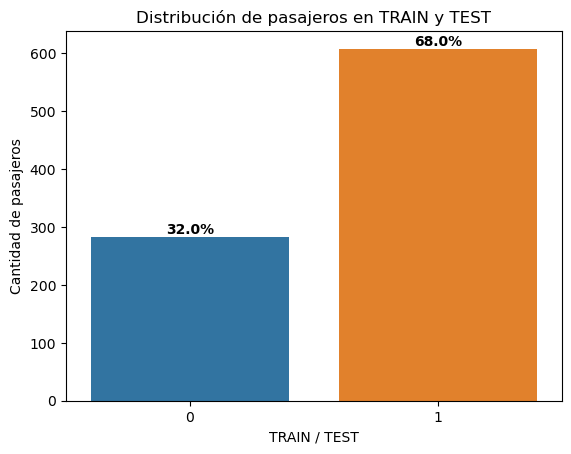

In [22]:
cantidad = len(df['Survived'])

sns.countplot(data = df,
              x = "TRAIN")
plt.xlabel('TRAIN / TEST')
plt.ylabel('Cantidad de pasajeros')
plt.title('Distribución de pasajeros en TRAIN y TEST')
ax = plt.gca()
for p in ax.patches:
    x_text = p.get_x() + p.get_width() / 2.0  # Calcula la posición x del texto
    y_text = p.get_height()  # Toma la altura de la columna
    ax.text(x_text, y_text, f'{str(round(int(y_text)/cantidad,2) * 100)}%', # Indica posición x e y, y texto a mostrar 
            ha = 'center', # Alineación horizontal 
            va = 'bottom',  # Alineación vertical
            fontsize = 10, color = 'black', fontweight = 'bold')
plt.show()

Text(0.5, 1.0, '¿Es la tasa de supervivencia igual en ambas subporciones de la muestra?')

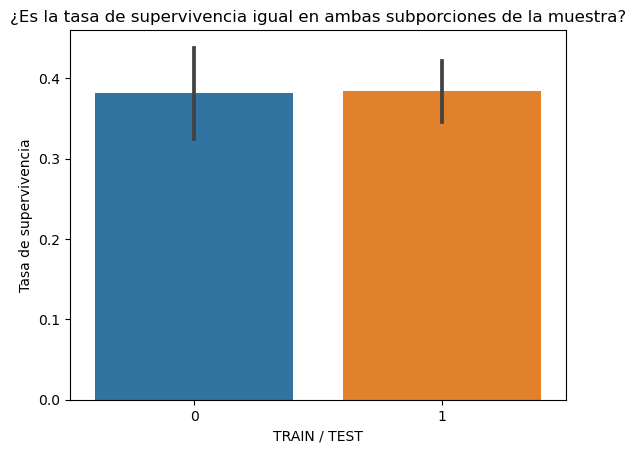

In [23]:
sns.barplot(data = df,
                x = 'TRAIN',
                y = 'Survived')
plt.xlabel('TRAIN / TEST')
plt.ylabel('Tasa de supervivencia')
plt.title('¿Es la tasa de supervivencia igual en ambas subporciones de la muestra?')

# Modelo Base

In [25]:
# Genero el modelo
formula = "Survived ~ Sex_Surv +  Age_Completa"
reg_log = smf.logit(formula, data = df[df['TRAIN']==1]).fit()

# Ver coeficientes y p valores
coeficientes = reg_log.params
pvalores = reg_log.pvalues
print("")
print("Coeficientes:")
print(coeficientes.round(4))
print("")
print("P-Values:")
print(pvalores.round(6))

Optimization terminated successfully.
         Current function value: 0.508746
         Iterations 5

Coeficientes:
Intercept      -2.4437
Sex_Surv        4.6516
Age_Completa    0.0022
dtype: float64

P-Values:
Intercept       0.000000
Sex_Surv        0.000000
Age_Completa    0.783385
dtype: float64


In [26]:
# Predicciones 
df['Predict_Prob_RegLog_1'] = reg_log.predict(df)

<Axes: xlabel='Predict_Prob_RegLog_1', ylabel='Probability'>

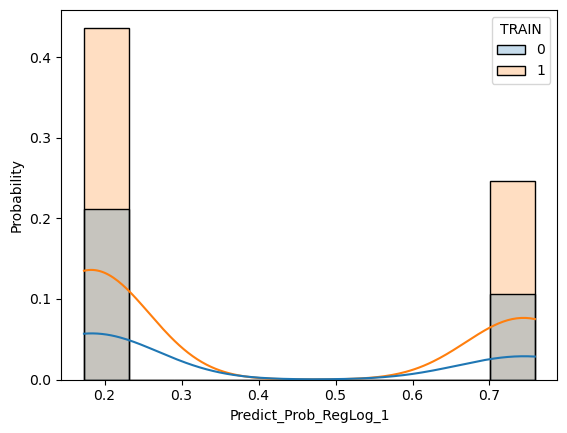

In [28]:
# Análisis de distribución: ¿Las predicciones se distribuyen igual?
sns.histplot(data = df,
             x = 'Predict_Prob_RegLog_1',
             bins = 10,            
             alpha = 0.25,
             kde = True,
             stat='probability',
             hue = 'TRAIN')

# Métricas
A continuación vamos a calcular algunas métricas y análisis interesantes: 
1. **Matriz de confusión:** usaremos un corte de 40% para definir la clasificación de sobrevive o no. Es decir, si la probabilidad es > 0.4, entonces asumimos que sobrevive. 
2. **Métricas que surgen de esa matriz** 
3. **Curva de ROC y AUC**

In [30]:
# 1) Matriz de Confusión 
# Paso 1: Clasificar a los pasajeros según las predicciones 
df['Survived_Pred_1'] = np.where(df['Predict_Prob_RegLog_1'] > 0.4, 1, 0)

# Paso 2:  Calcular la matriz de confusión para test y train
confusion_entrenamiento = confusion_matrix(df[df['TRAIN'] == 1]['Survived'], 
                                           df[df['TRAIN'] == 1]['Survived_Pred_1'])

confusion_test = confusion_matrix(df[df['TRAIN'] == 0]['Survived'], 
                                    df[df['TRAIN'] == 0]['Survived_Pred_1'])

print('Matriz de Confusión en entrenamiento:')
print(confusion_entrenamiento)
print('Matriz de Confusión en testeo:')
print(confusion_test)


Matriz de Confusión en entrenamiento:
[[318  56]
 [ 71 163]]
Matriz de Confusión en testeo:
[[150  25]
 [ 38  70]]


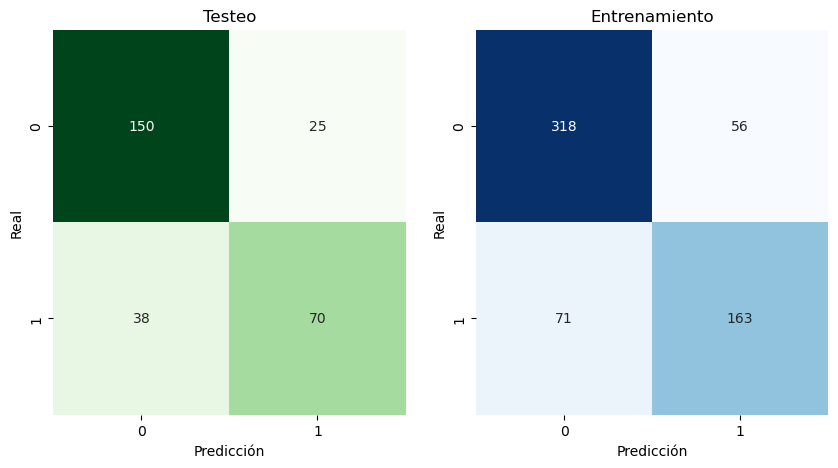

In [31]:
# Paso 3: Grafico
# Primero defino la estructura de mis gráficos a mostras
fig, ax = plt.subplots(nrows = 1,
                      ncols = 2,
                      figsize = (10,5)) 

# Luego indico lo que voy a dibujar en el primer cuadrante
sns.heatmap(confusion_test, 
            annot=True, fmt='d', cmap='Greens', cbar=False, 
            ax=ax[0])
ax[0].set_title('Testeo')
ax[0].set_xlabel('Predicción')
ax[0].set_ylabel('Real')

# Luego indico lo que voy a dibujar en el segundo cuadrante
sns.heatmap(confusion_entrenamiento, 
            annot=True, fmt='d', cmap='Blues', cbar=False, 
            ax=ax[1])
ax[1].set_title('Entrenamiento')
ax[1].set_xlabel('Predicción')
ax[1].set_ylabel('Real')

# Muestra
plt.show()


C:\Users\usernosis\AppData\Local\Temp\ipykernel_17584\293990175.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas = metricas.append(nuevo_dato, ignore_index=True)
C:\Users\usernosis\AppData\Local\Temp\ipykernel_17584\293990175.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas = metricas.append(nuevo_dato, ignore_index=True)
C:\Users\usernosis\AppData\Local\Temp\ipykernel_17584\293990175.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas = metricas.append(nuevo_dato, ignore_index=True)
C:\Users\usernosis\AppData\Local\Temp\ipykernel_17584\293990175.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  me

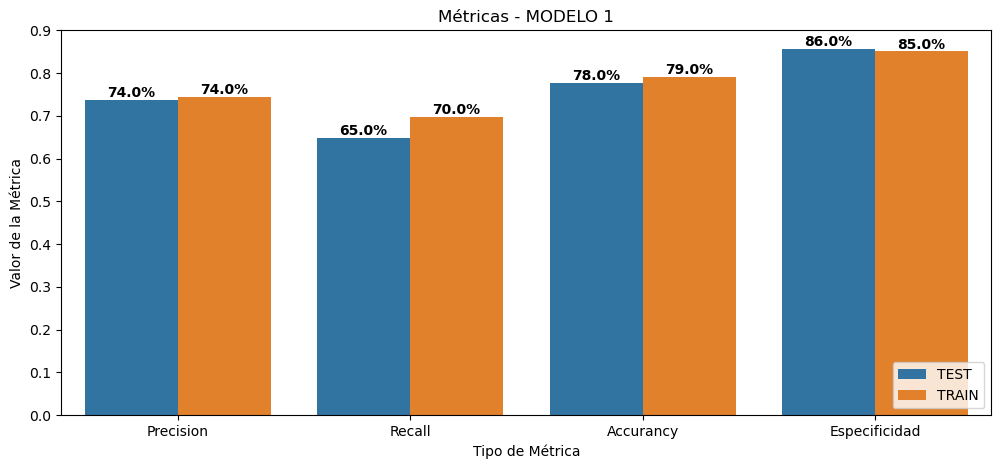

In [32]:
# 2) Calculemos las metricas, para eso vamos a guardar el resultado de cada cuadrante para utilizarlos 

# Paso 1: capturo cada uno de los elementos de la matriz de confusión 
Total_TEST = sum(sum(confusion_test))
Total_TRAIN = sum(sum(confusion_entrenamiento))
TP_TEST = confusion_test[1,1]
TP_TRAIN = confusion_entrenamiento[1,1]
TN_TEST = confusion_test[0,0]
TN_TRAIN = confusion_entrenamiento[0,0]
FP_TEST = confusion_test[0,1]
FP_TRAIN = confusion_entrenamiento[0,1]
FN_TEST = confusion_test[1,0]
FN_TRAIN = confusion_entrenamiento[1,0]

# Paso 2: Calculo métricas
Precision_TEST = TP_TEST / (TP_TEST + FP_TEST)
Precision_TRAIN = TP_TRAIN / (TP_TRAIN + FP_TRAIN)
Recall_TEST = TP_TEST / (TP_TEST + FN_TEST)
Recall_TRAIN = TP_TRAIN / (TP_TRAIN + FN_TRAIN)
Accurancy_TEST = (TP_TEST + TN_TEST) / Total_TEST
Accurancy_TRAIN = (TP_TRAIN + TN_TRAIN) / Total_TRAIN
Especificidad_TEST = TN_TEST / (TN_TEST + FP_TEST)
Especificidad_TRAIN = TN_TRAIN / (TN_TRAIN + FP_TRAIN)

# Paso 3: Presento todo en una misma tabla 
metricas = pd.DataFrame(columns=['Poblacion', 'Metrica','Valor'])

# Precision
nuevo_dato = {'Poblacion': 'TEST', 
              'Metrica': 'Precision',
              'Valor': Precision_TEST}
metricas = metricas.append(nuevo_dato, ignore_index=True)
nuevo_dato = {'Poblacion': 'TRAIN', 
              'Metrica': 'Precision',
              'Valor': Precision_TRAIN}
metricas = metricas.append(nuevo_dato, ignore_index=True)

# Recall
nuevo_dato = {'Poblacion': 'TEST', 
              'Metrica': 'Recall',
              'Valor': Recall_TEST}
metricas = metricas.append(nuevo_dato, ignore_index=True)
nuevo_dato = {'Poblacion': 'TRAIN', 
              'Metrica': 'Recall',
              'Valor': Recall_TRAIN}
metricas = metricas.append(nuevo_dato, ignore_index=True)

# Accurancy
nuevo_dato = {'Poblacion': 'TEST', 
              'Metrica': 'Accurancy',
              'Valor': Accurancy_TEST}
metricas = metricas.append(nuevo_dato, ignore_index=True)
nuevo_dato = {'Poblacion': 'TRAIN', 
              'Metrica': 'Accurancy',
              'Valor': Accurancy_TRAIN}
metricas = metricas.append(nuevo_dato, ignore_index=True)

# Especificidad
nuevo_dato = {'Poblacion': 'TEST', 
              'Metrica': 'Especificidad',
              'Valor': Especificidad_TEST}
metricas = metricas.append(nuevo_dato, ignore_index=True)
nuevo_dato = {'Poblacion': 'TRAIN', 
              'Metrica': 'Especificidad',
              'Valor': Especificidad_TRAIN}
metricas = metricas.append(nuevo_dato, ignore_index=True)

# Paso 4: Grafico 
plt.figure(figsize=(12, 5))
sns.barplot(data = metricas,
                x = 'Metrica',
                y = 'Valor',
                hue = 'Poblacion')
plt.xlabel('Tipo de Métrica')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas - MODELO 1')
ax = plt.gca()
for p in ax.patches:
    x_text = p.get_x() + p.get_width() / 2.0  # Calcula la posición x del texto
    y_text = p.get_height()  # Toma la altura de la columna
    ax.text(x_text, y_text, f'{str(round(y_text,2) * 100)}%', # Indica posición x e y, y texto a mostrar 
            ha = 'center', # Alineación horizontal 
            va = 'bottom',  # Alineación vertical
            fontsize = 10, color = 'black', fontweight = 'bold')

plt.legend(loc='lower right')    
metricas_1 = plt.gcf()
plt.show()


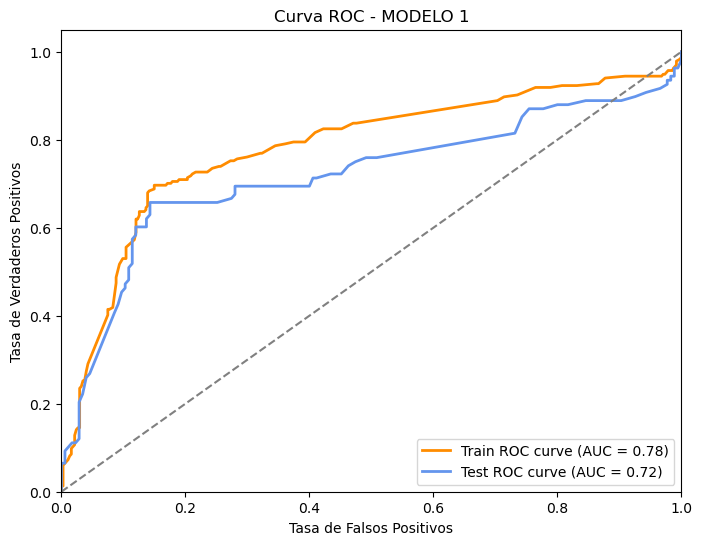

In [33]:
# 3) Curvas de ROC
# Calcula las curvas ROC y el área bajo la curva (AUC) para entrenamiento y prueba

y_train = df.loc[df['TRAIN'] == 1,'Survived']
y_train_proba = df.loc[df['TRAIN'] == 1,'Predict_Prob_RegLog_1']
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

y_test = df.loc[df['TRAIN'] == 0,'Survived']
y_test_proba = df.loc[df['TRAIN'] == 0,'Predict_Prob_RegLog_1']
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafica las curvas ROC en el mismo gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - MODELO 1')
plt.legend(loc='lower right')
roc_1 = plt.gcf()
plt.show()

# Modelo 2
Vamos a intentar incorporar más variables. 

In [34]:
# Genero el modelo
formula = "Survived ~ Sex_Surv + Pclass_Surv + Age_Completa"
reg_log_2 = smf.logit(formula, data = df[df['TRAIN'] == 1]).fit()

# Ver coeficientes y p valores
coeficientes = reg_log_2.params
pvalores = reg_log_2.pvalues
print("")
print("Coeficientes:")
print(coeficientes.round(4))
print("")
print("P-Values:")
print(pvalores.round(6))

Optimization terminated successfully.
         Current function value: 0.445099
         Iterations 6

Coeficientes:
Intercept      -4.0985
Sex_Surv        4.7949
Pclass_Surv     6.0149
Age_Completa   -0.0255
dtype: float64

P-Values:
Intercept       0.000000
Sex_Surv        0.000000
Pclass_Surv     0.000000
Age_Completa    0.005006
dtype: float64


In [35]:
# Predicciones 
df['Predict_Prob_RegLog_2'] = reg_log_2.predict(df)

In [36]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Age_Completa,Sex_Surv,Pclass_Surv,TRAIN,Predict_Prob_RegLog_1,Survived_Pred_1,Predict_Prob_RegLog_2
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,22.0,0.188908,0.242363,1,0.179983,0,0.091494
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,38.0,0.742038,0.629630,0,0.748714,1,0.907066
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,26.0,0.742038,0.242363,0,0.743705,1,0.563343
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,35.0,0.742038,0.629630,1,0.747468,1,0.913313
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,35.0,0.188908,0.242363,0,0.184250,0,0.067434


In [42]:
# 1) Matriz de Confusión 
# Paso 1: Clasificar a los pasajeros según las predicciones 
df['Survived_Pred_2'] = np.where(df['Predict_Prob_RegLog_2'] > 0.5, 1, 0)

# Paso 2:  Calcular la matriz de confusión para test y train
confusion_entrenamiento = confusion_matrix(df[df['TRAIN'] == 1]['Survived'], 
                                           df[df['TRAIN'] == 1]['Survived_Pred_2'])

confusion_test = confusion_matrix(df[df['TRAIN'] == 0]['Survived'], 
                                    df[df['TRAIN'] == 0]['Survived_Pred_2'])

print('Matriz de Confusión en entrenamiento:')
print(confusion_entrenamiento)
print('Matriz de Confusión en testeo:')
print(confusion_test)

Matriz de Confusión en entrenamiento:
[[322  52]
 [ 69 165]]
Matriz de Confusión en testeo:
[[153  22]
 [ 38  70]]


C:\Users\usernosis\AppData\Local\Temp\ipykernel_17584\614050914.py:32: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas = metricas.append(nuevo_dato, ignore_index=True)
C:\Users\usernosis\AppData\Local\Temp\ipykernel_17584\614050914.py:36: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas = metricas.append(nuevo_dato, ignore_index=True)
C:\Users\usernosis\AppData\Local\Temp\ipykernel_17584\614050914.py:42: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metricas = metricas.append(nuevo_dato, ignore_index=True)
C:\Users\usernosis\AppData\Local\Temp\ipykernel_17584\614050914.py:46: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  me

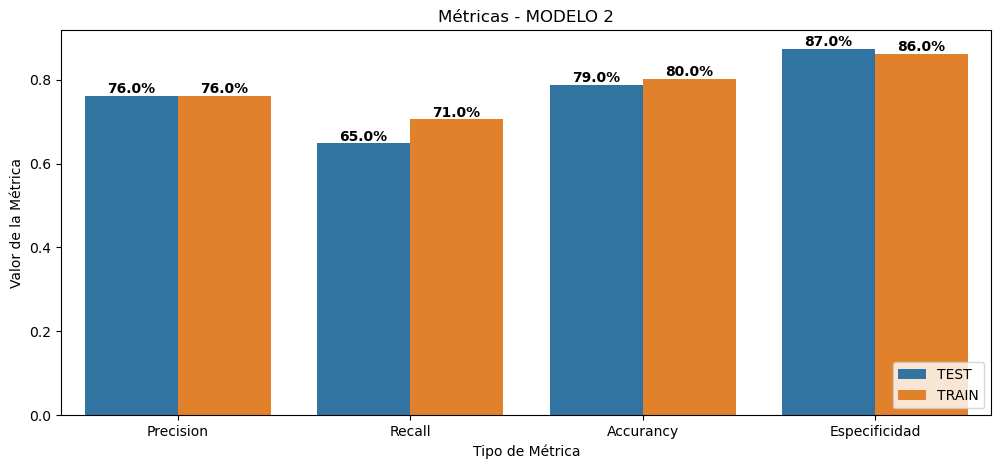

In [43]:
# 2) Calculemos las metricas, para eso vamos a guardar el resultado de cada cuadrante para utilizarlos 

# Paso 1: capturo cada uno de los elementos de la matriz de confusión 
Total_TEST = sum(sum(confusion_test))
Total_TRAIN = sum(sum(confusion_entrenamiento))
TP_TEST = confusion_test[1,1]
TP_TRAIN = confusion_entrenamiento[1,1]
TN_TEST = confusion_test[0,0]
TN_TRAIN = confusion_entrenamiento[0,0]
FP_TEST = confusion_test[0,1]
FP_TRAIN = confusion_entrenamiento[0,1]
FN_TEST = confusion_test[1,0]
FN_TRAIN = confusion_entrenamiento[1,0]

# Paso 2: Calculo métricas
Precision_TEST = TP_TEST / (TP_TEST + FP_TEST)
Precision_TRAIN = TP_TRAIN / (TP_TRAIN + FP_TRAIN)
Recall_TEST = TP_TEST / (TP_TEST + FN_TEST)
Recall_TRAIN = TP_TRAIN / (TP_TRAIN + FN_TRAIN)
Accurancy_TEST = (TP_TEST + TN_TEST) / Total_TEST
Accurancy_TRAIN = (TP_TRAIN + TN_TRAIN) / Total_TRAIN
Especificidad_TEST = TN_TEST / (TN_TEST + FP_TEST)
Especificidad_TRAIN = TN_TRAIN / (TN_TRAIN + FP_TRAIN)

# Paso 3: Presento todo en una misma tabla 
metricas = pd.DataFrame(columns=['Poblacion', 'Metrica','Valor'])

# Precision
nuevo_dato = {'Poblacion': 'TEST', 
              'Metrica': 'Precision',
              'Valor': Precision_TEST}
metricas = metricas.append(nuevo_dato, ignore_index=True)
nuevo_dato = {'Poblacion': 'TRAIN', 
              'Metrica': 'Precision',
              'Valor': Precision_TRAIN}
metricas = metricas.append(nuevo_dato, ignore_index=True)

# Recall
nuevo_dato = {'Poblacion': 'TEST', 
              'Metrica': 'Recall',
              'Valor': Recall_TEST}
metricas = metricas.append(nuevo_dato, ignore_index=True)
nuevo_dato = {'Poblacion': 'TRAIN', 
              'Metrica': 'Recall',
              'Valor': Recall_TRAIN}
metricas = metricas.append(nuevo_dato, ignore_index=True)

# Accurancy
nuevo_dato = {'Poblacion': 'TEST', 
              'Metrica': 'Accurancy',
              'Valor': Accurancy_TEST}
metricas = metricas.append(nuevo_dato, ignore_index=True)
nuevo_dato = {'Poblacion': 'TRAIN', 
              'Metrica': 'Accurancy',
              'Valor': Accurancy_TRAIN}
metricas = metricas.append(nuevo_dato, ignore_index=True)

# Especificidad
nuevo_dato = {'Poblacion': 'TEST', 
              'Metrica': 'Especificidad',
              'Valor': Especificidad_TEST}
metricas = metricas.append(nuevo_dato, ignore_index=True)
nuevo_dato = {'Poblacion': 'TRAIN', 
              'Metrica': 'Especificidad',
              'Valor': Especificidad_TRAIN}
metricas = metricas.append(nuevo_dato, ignore_index=True)

# Paso 4: Grafico 
plt.figure(figsize=(12, 5))
sns.barplot(data = metricas,
                x = 'Metrica',
                y = 'Valor',
                hue = 'Poblacion')
plt.xlabel('Tipo de Métrica')
plt.ylabel('Valor de la Métrica')
plt.title('Métricas - MODELO 2')
ax = plt.gca()
for p in ax.patches:
    x_text = p.get_x() + p.get_width() / 2.0  # Calcula la posición x del texto
    y_text = p.get_height()  # Toma la altura de la columna
    ax.text(x_text, y_text, f'{str(round(y_text,2) * 100)}%', # Indica posición x e y, y texto a mostrar 
            ha = 'center', # Alineación horizontal 
            va = 'bottom',  # Alineación vertical
            fontsize = 10, color = 'black', fontweight = 'bold')

plt.legend(loc='lower right')    
plt.show()


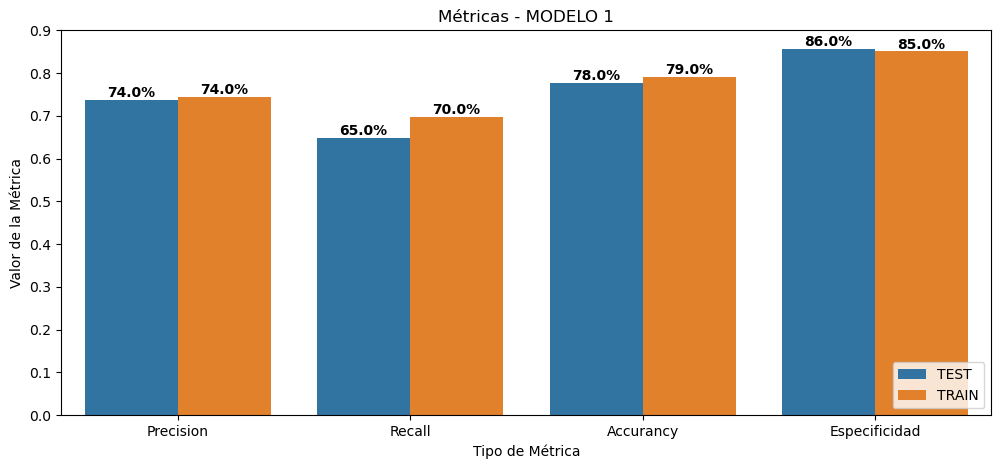

In [39]:
metricas_1

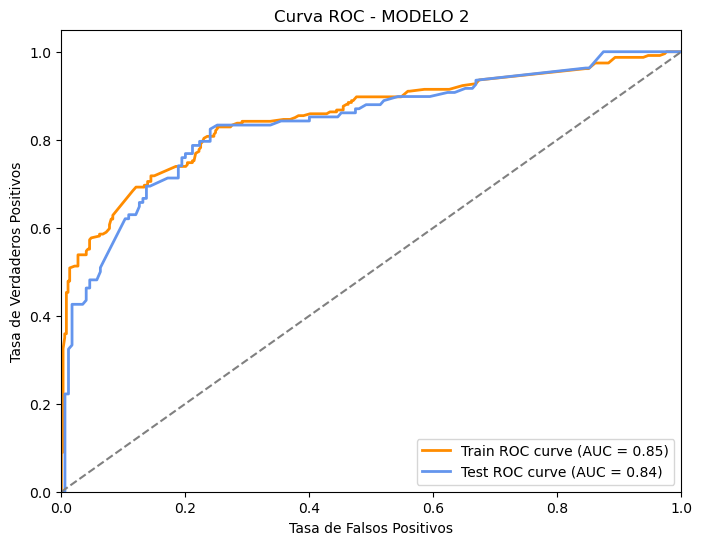

In [40]:
# 3) Curvas de ROC
# Calcula las curvas ROC y el área bajo la curva (AUC) para entrenamiento y prueba

y_train = df.loc[df['TRAIN'] == 1,'Survived']
y_train_proba = df.loc[df['TRAIN'] == 1,'Predict_Prob_RegLog_2']
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_proba)
roc_auc_train = auc(fpr_train, tpr_train)

y_test = df.loc[df['TRAIN'] == 0,'Survived']
y_test_proba = df.loc[df['TRAIN'] == 0,'Predict_Prob_RegLog_2']
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_proba)
roc_auc_test = auc(fpr_test, tpr_test)

# Grafica las curvas ROC en el mismo gráfico
plt.figure(figsize=(8, 6))
plt.plot(fpr_train, tpr_train, color='darkorange', lw=2, label=f'Train ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=2, label=f'Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.title('Curva ROC - MODELO 2')
plt.legend(loc='lower right')
plt.show()

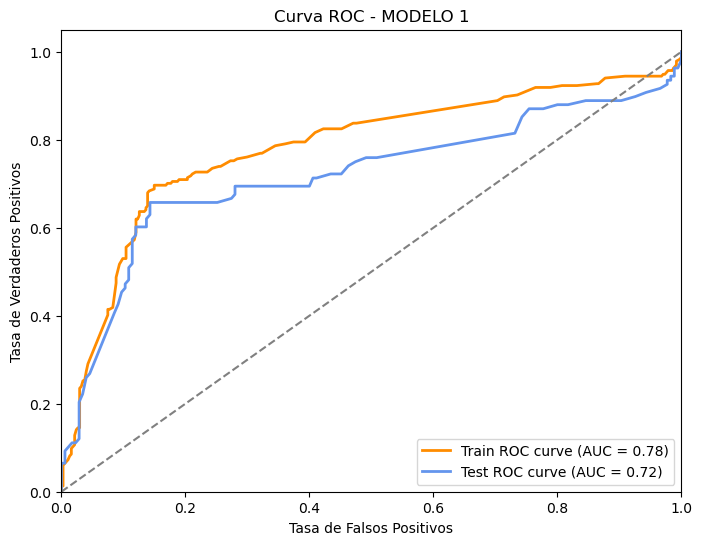

In [41]:
roc_1